In [1]:
from utils.hybrid import Hybrid
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH
import torch
import cv2
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 6
config['l2'] = 5

/root/dev/PulmoScanX/utils/utils.py:12: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:654.)
  sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))


In [3]:
hybrid = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid.load_state_dict(torch.load("../models/HybridGNet/best.pt"))
hybrid.eval()
print('Model loaded')

Model loaded


In [45]:
from torchvision import transforms
from skimage import io, transform

class Rescale(np.ndarray):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        print(f"Rescaling image from {h}x{w} to {self.output_size}")
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        print(f"New size: {new_h}x{new_w}")
        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w, 1))

        return img
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        return image.transpose((2, 0, 1))

def test_transform():
    return transforms.Compose([
        Rescale(1024),
        ToTensor()])

In [85]:
from PIL import Image
img_path = "../sample/JPCLN001.png"
#img_path = "../datasets/cxr/images/00000001_000.png"
#img_pil = Image.open(img_path).convert("L")  # 'L' mode ensures grayscale
# image is grayscale: shape (H, W)
image = io.imread(img_path).astype('float32') / 255.0
#image = np.expand_dims(image, axis=2)

# Resize to (1024, 1024)
image = transform.resize(image, (1024, 1024), anti_aliasing=True)  # shape: (1024, 1024)

# Transpose to (C, H, W)
image = image.transpose((2, 0, 1))  # shape: (3, 1024, 1024)
data = torch.from_numpy(image).float()
data = torch.unsqueeze(data, 0).to(device)

In [86]:
data.shape

torch.Size([1, 3, 1024, 1024])

In [87]:
with torch.no_grad():
    output = hybrid(data)
output = output.cpu().numpy().reshape(-1) 
output = np.clip(output, 0, 1)[:240]

RuntimeError: weight should contain 3 elements not 1

In [83]:
import matplotlib.pyplot as plt

#important vertex
RL = [0, 21, 29]
LL = [0, 21, 27, 40, 44]
H = [0, 6, 12, 18]

def reverseVector(vector):
    RLUNG = 44
    LLUNG = 50
    HEART = 26
    RCLAV = 23
    #LCLAV = 23
    
    p1 = RLUNG*2
    p2 = p1 + LLUNG*2
    p3 = p2 + HEART*2
    p4 = p3 + RCLAV*2
    
    rl = vector[:p1].reshape(-1,2)
    ll = vector[p1:p2].reshape(-1,2)
    h = vector[p2:p3].reshape(-1,2)
    rc = vector[p3:p4].reshape(-1,2)
    lc = vector[p4:].reshape(-1,2)
    
    return rl, ll, h, rc, lc

def draw_organ(ax, array, color = 'b', bigger = None):
    N = array.shape[0]
    
    for i in range(0, N):
        x, y = array[i,:]
        
        if bigger is not None:
            if i in bigger:
                circ = plt.Circle((x, y), radius=9, color=color, fill = True)
                ax.add_patch(circ)
                circ = plt.Circle((x, y), radius=3, color='white', fill = True)
            else:
                circ = plt.Circle((x, y), radius=3, color=color, fill = True)
        else:
            circ = plt.Circle((x, y), radius=3, color=color, fill = True)
            
        ax.add_patch(circ)
    return

def draw_lines(ax, array, color = 'b'):
    N = array.shape[0]
    
    for i in range(0, N):
        x1, y1 = array[i-1,:]
        x2, y2 = array[i,:]
        
        ax.plot([x1, x2], [y1, y2], color=color, linestyle='-', linewidth=1)
    return

def drawOrgans(ax, vector, title = '', img =  None):
    
    vector = vector.reshape(-1, 1)
    right_lung, left_lung, heart, right_clavicle, left_clavicle = reverseVector(vector)
    
    if img is not None:
        plt.imshow(img, cmap='gray')
    
    #ax.set_ylim(1024, 0)
    #ax.set_xlim(0, 1024)
    #fig.gca().set_aspect('equal', adjustable='box')
    
    draw_lines(ax, right_lung, 'r')
    draw_lines(ax, left_lung, 'g')
    draw_lines(ax, heart, 'y')
    draw_lines(ax, right_clavicle, 'b')
    draw_lines(ax, left_clavicle, 'darkorange')
    
    draw_organ(ax, right_lung, 'r', RL)
    draw_organ(ax, left_lung, 'g', LL)
    draw_organ(ax, heart, 'y', H)
    draw_organ(ax, right_clavicle, 'b')
    draw_organ(ax, left_clavicle, 'darkorange')

    ax.set_title(title)
    
    return

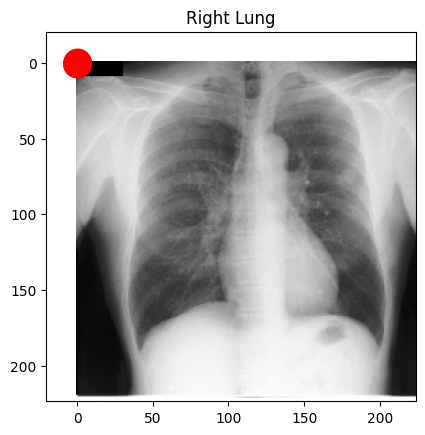

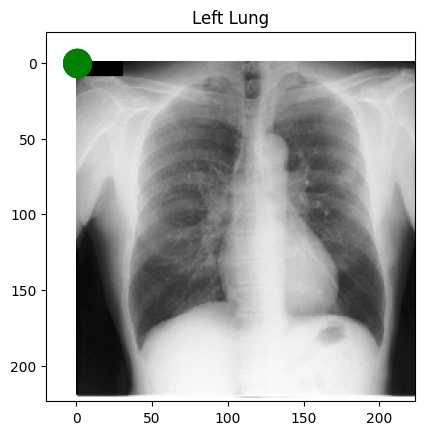

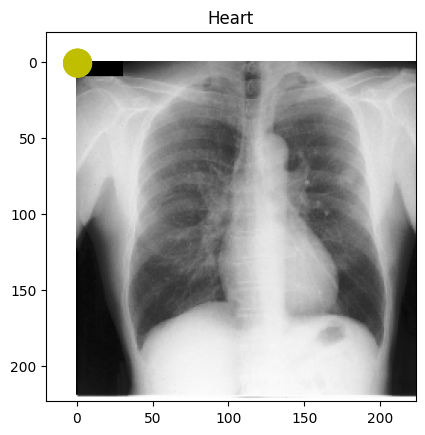

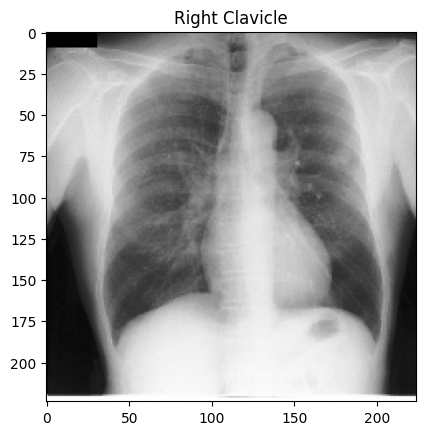

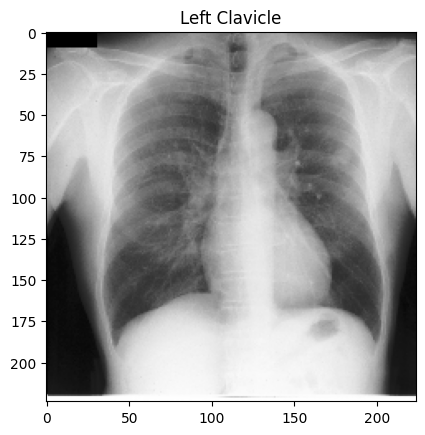

In [84]:
def draw_single_organ(ax, organ_vector, color, organ_shape=None):
    draw_lines(ax, organ_vector, color)
    if organ_shape is not None:
        draw_organ(ax, organ_vector, color, organ_shape)

def show_each_organ(vector, img=None):
    vector = vector.reshape(-1, 1)
    right_lung, left_lung, heart, right_clavicle, left_clavicle = reverseVector(vector)
    organs = [
        ("Right Lung", right_lung, 'r', RL),
        ("Left Lung", left_lung, 'g', LL),
        ("Heart", heart, 'y', H),
        ("Right Clavicle", right_clavicle, 'b', None),
        ("Left Clavicle", left_clavicle, 'darkorange', None),
    ]

    for title, organ_vec, color, shape in organs:
        fig, ax = plt.subplots()
        if img is not None:
            ax.imshow(img, cmap='gray')
        draw_single_organ(ax, organ_vec, color, shape)
        ax.set_title(title)
        plt.show()

show_each_organ(output, img_pil)